In this task we are required to make a Binary classification 

First import all need librarries

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [67]:
df = pd.read_csv('first inten project.csv')
df.head()

Booking_ID  number of adults  number of children  number of weekend nights  \
0   INN00001                 1                   1                         2   
1   INN00002                 1                   0                         1   
2   INN00003                 2                   1                         1   
3   INN00004                 1                   0                         0   
4   INN00005                 1                   0                         1   

   number of week nights  type of meal  car parking space    room type  \
0                      5   Meal Plan 1                  0  Room_Type 1   
1                      3  Not Selected                  0  Room_Type 1   
2                      3   Meal Plan 1                  0  Room_Type 1   
3                      2   Meal Plan 1                  0  Room_Type 1   
4                      2  Not Selected                  0  Room_Type 1   

   lead time market segment type  repeated  P-C  P-not-C  average price   \
0        224             Offline         0    0        0           88.00   
1          5              Online         0    0        0          106.68   
2          1              Online         0    0        0           50.00   
3        211              Online         0    0        0          100.00   
4         48              Online         0    0        0           77.00   

   special requests date of reservation booking status  
0                 0           10/2/2015   Not_Canceled  
1                 1           11/6/2018   Not_Canceled  
2                 0           2/28/2018       Canceled  
3                 1           5/20/2017       Canceled  
4                 0           4/11/2018       Canceled

Data Preprocessing

Check for Null Values and Data Types

Check for any Extra Whitespace in the Data

In [68]:
#check for null values
null_values = df.isnull().sum()
print(null_values)

#check for duplicates
duplicates = df.duplicated().sum()
print(duplicates)

Booking_ID                  0
number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
date of reservation         0
booking status              0
dtype: int64
0


In [69]:
# Clean extra whitespace in categorical data and standardize column names
categorical_columns = df.select_dtypes(include=['object']).columns

# Strip any leading/trailing whitespace from categorical columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.str.strip())

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Display the first few rows after cleaning
df.head()


booking_id  number_of_adults  number_of_children  number_of_weekend_nights  \
0   INN00001                 1                   1                         2   
1   INN00002                 1                   0                         1   
2   INN00003                 2                   1                         1   
3   INN00004                 1                   0                         0   
4   INN00005                 1                   0                         1   

   number_of_week_nights  type_of_meal  car_parking_space    room_type  \
0                      5   Meal Plan 1                  0  Room_Type 1   
1                      3  Not Selected                  0  Room_Type 1   
2                      3   Meal Plan 1                  0  Room_Type 1   
3                      2   Meal Plan 1                  0  Room_Type 1   
4                      2  Not Selected                  0  Room_Type 1   

   lead_time market_segment_type  repeated  p-c  p-not-c  average_price  \
0        224             Offline         0    0        0          88.00   
1          5              Online         0    0        0         106.68   
2          1              Online         0    0        0          50.00   
3        211              Online         0    0        0         100.00   
4         48              Online         0    0        0          77.00   

   special_requests date_of_reservation booking_status  
0                 0           10/2/2015   Not_Canceled  
1                 1           11/6/2018   Not_Canceled  
2                 0           2/28/2018       Canceled  
3                 1           5/20/2017       Canceled  
4                 0           4/11/2018       Canceled

In [70]:
#check data types
data_types = df.dtypes
print(data_types)

booking_id                   object
number_of_adults              int64
number_of_children            int64
number_of_weekend_nights      int64
number_of_week_nights         int64
type_of_meal                 object
car_parking_space             int64
room_type                    object
lead_time                     int64
market_segment_type          object
repeated                      int64
p-c                           int64
p-not-c                       int64
average_price               float64
special_requests              int64
date_of_reservation          object
booking_status               object
dtype: object


In [71]:
#check for unique values
unique_values = df.nunique()
print(unique_values)

booking_id                  36285
number_of_adults                5
number_of_children              6
number_of_weekend_nights        8
number_of_week_nights          18
type_of_meal                    4
car_parking_space               2
room_type                       7
lead_time                     352
market_segment_type             5
repeated                        2
p-c                             9
p-not-c                        59
average_price                3930
special_requests                6
date_of_reservation           553
booking_status                  2
dtype: int64


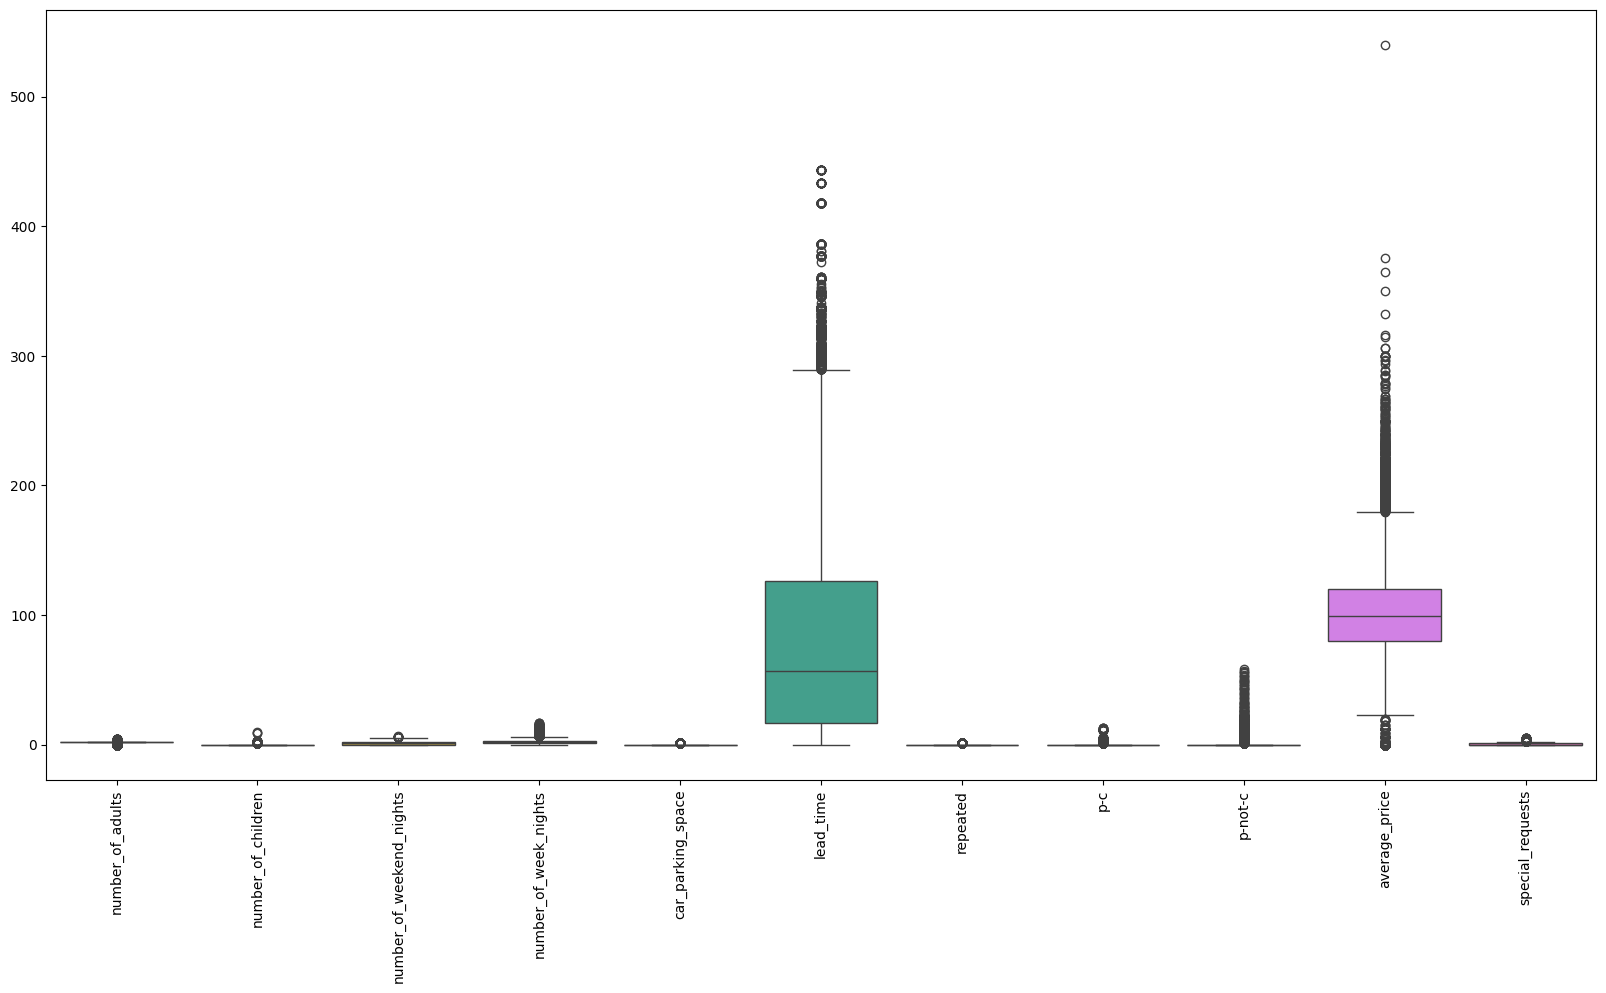

In [72]:
#check for outliers
plt.figure(figsize=(20, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()


In [73]:
#check for outliers

def find_outliers(df):
    '''
    Find outliers in a DataFrame

    Parameters
    ----------
    df : pandas.DataFrame
    '''
    outliers = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column].tolist()
            print(f"Number of outliers in column {column}: {len(outliers[column])}")
    return outliers

def remove_outliers(df):
    '''
    Remove outliers from a DataFrame

    Parameters
    ----------
    df : pandas.DataFrame
    '''
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df


In [74]:
outliers = find_outliers(df)
print(outliers)


Number of outliers in column number_of_adults: 10175
Number of outliers in column number_of_children: 2702
Number of outliers in column number_of_weekend_nights: 21
Number of outliers in column number_of_week_nights: 324
Number of outliers in column car_parking_space: 1124
Number of outliers in column lead_time: 1332
Number of outliers in column repeated: 930
Number of outliers in column p-c: 338
Number of outliers in column p-not-c: 812
Number of outliers in column average_price: 1696
Number of outliers in column special_requests: 762
{'number_of_adults': [1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 0, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 4, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1

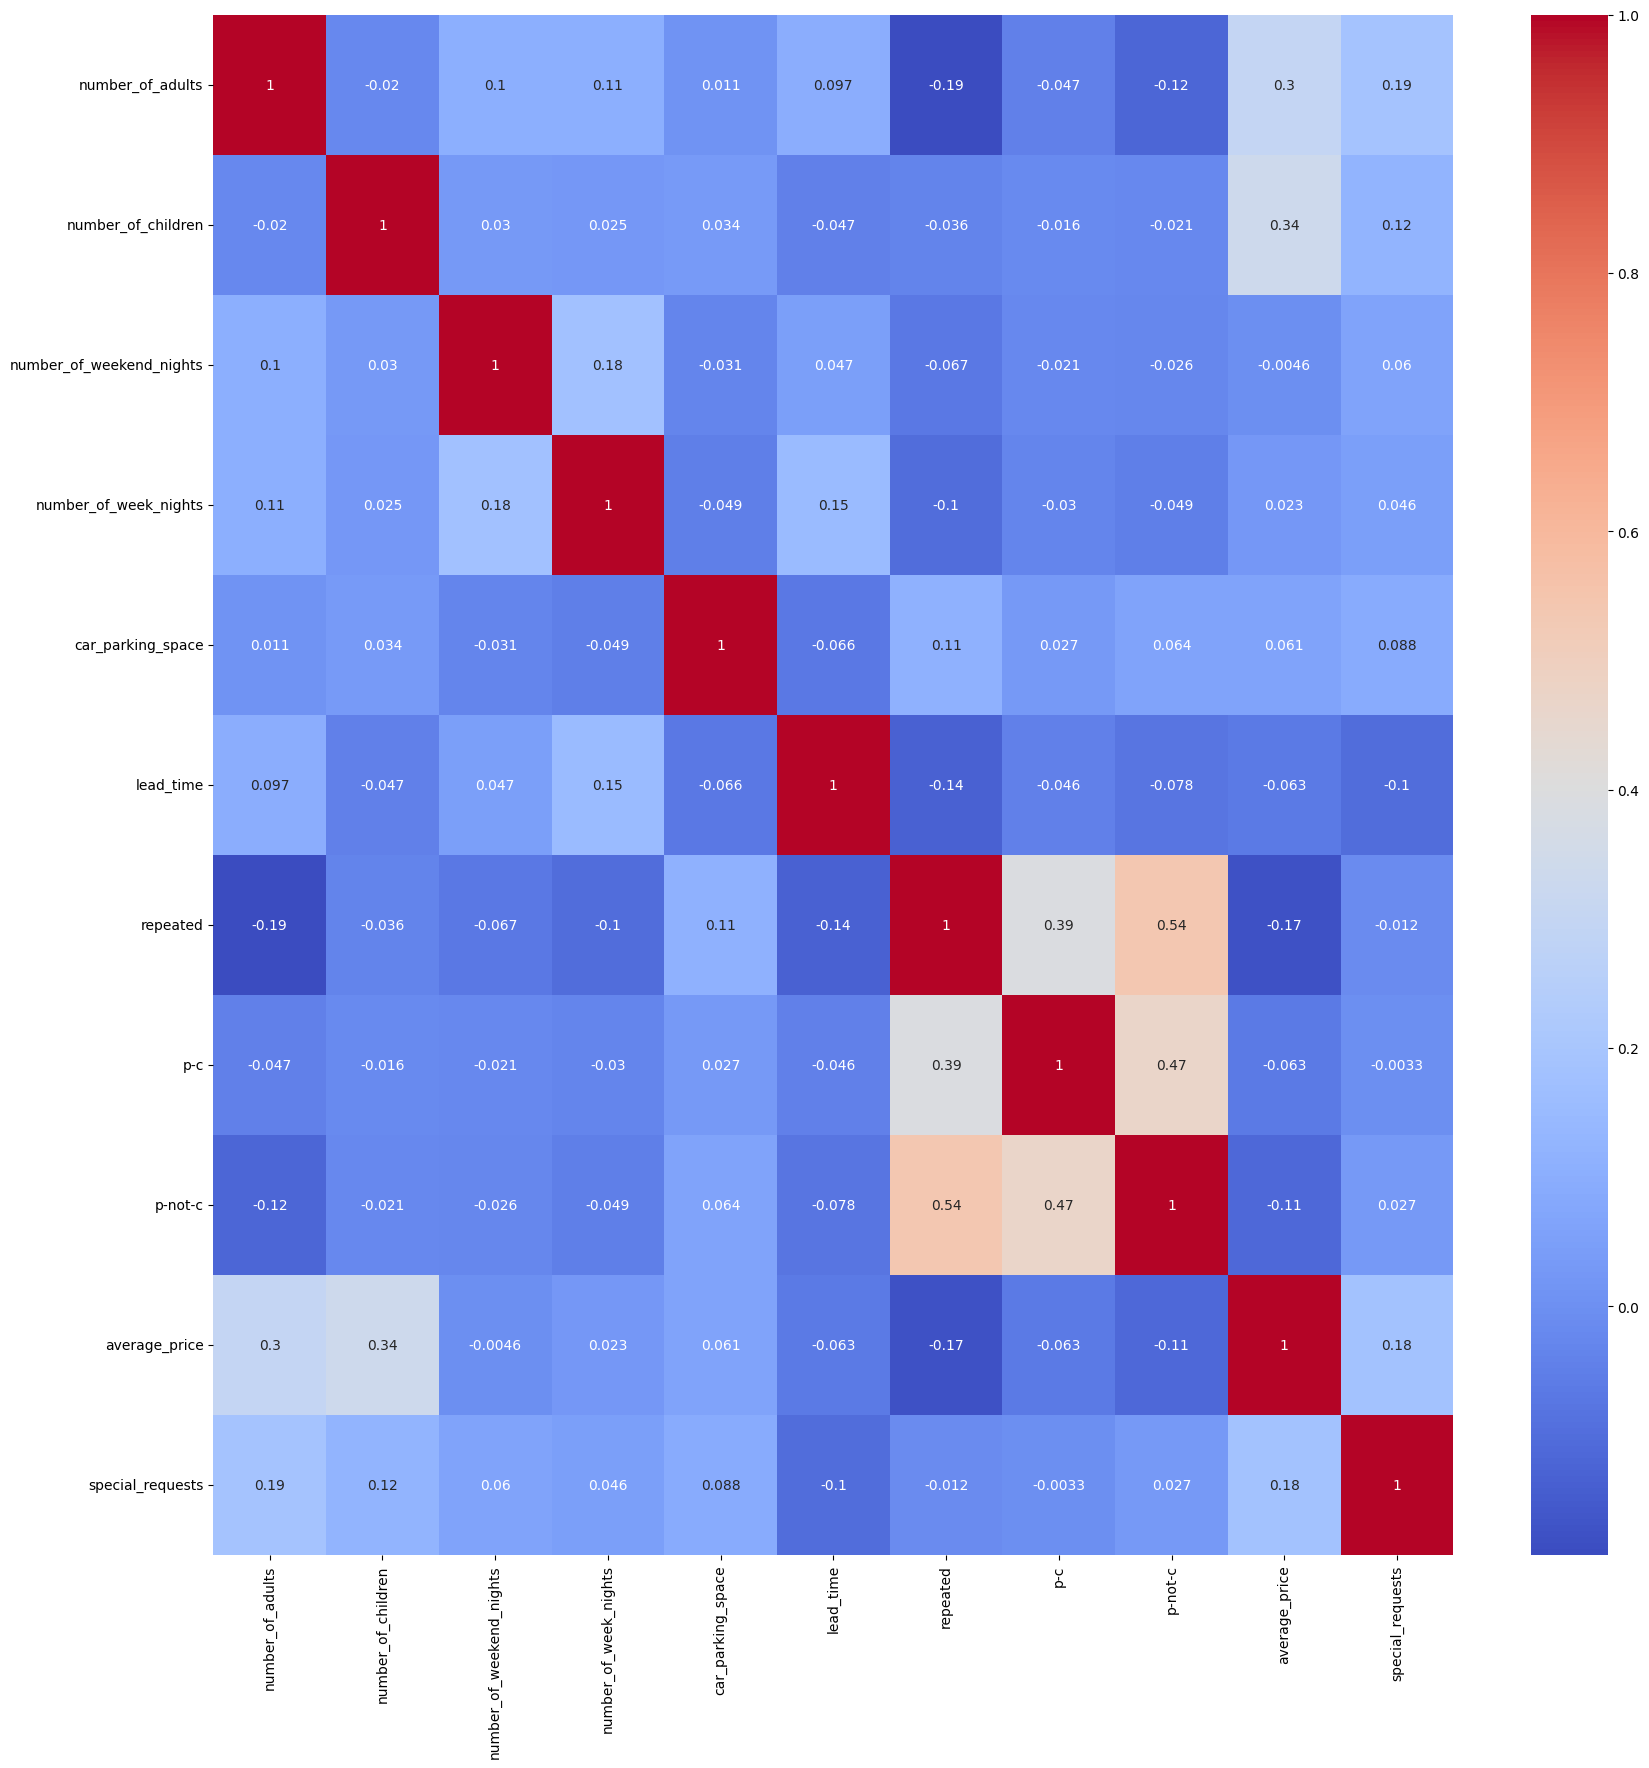

In [75]:
# Exclude non-numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [76]:
# Remove outliers
df = remove_outliers(df)
df.shape

(21189, 17)

In [77]:
df.head()

booking_id  number_of_adults  number_of_children  number_of_weekend_nights  \
12   INN00013                 2                   0                         2   
14   INN00015                 2                   0                         0   
15   INN00016                 2                   0                         0   
17   INN00018                 2                   0                         1   
18   INN00019                 2                   0                         2   

    number_of_week_nights  type_of_meal  car_parking_space    room_type  \
12                      1  Not Selected                  0  Room_Type 1   
14                      2   Meal Plan 1                  0  Room_Type 1   
15                      2   Meal Plan 2                  0  Room_Type 1   
17                      3  Not Selected                  0  Room_Type 1   
18                      2   Meal Plan 1                  0  Room_Type 1   

    lead_time market_segment_type  repeated  p-c  p-not-c  average_price  \
12         30              Online         0    0        0           88.0   
14         47              Online         0    0        0           94.5   
15        256              Online         0    0        0          115.0   
17          1              Online         0    0        0           96.0   
18         99              Online         0    0        0           65.0   

    special_requests date_of_reservation booking_status  
12                 0          11/26/2018       Canceled  
14                 2          10/20/2017   Not_Canceled  
15                 1           6/15/2018       Canceled  
17                 1           8/10/2017   Not_Canceled  
18                 0          10/30/2017       Canceled

In [78]:
def plot_relationships(df, target_column):
    """
    Plot the relationship between a target column and all other columns in the DataFrame.
    
    Args:
    df (pd.DataFrame): The input DataFrame.
    target_column (str): The target column to compare against other columns.
    """
    # Separate numerical and categorical columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Calculate total number of plots
    total_plots = len(numerical_columns) + len(categorical_columns) - 1  # Exclude the target column
    cols = 2  # Number of columns in the subplot grid
    rows = (total_plots + cols - 1) // cols  # Calculate the required number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    plot_index = 0

    # Plot for numerical columns
    for column in tqdm(numerical_columns, desc="Plotting numerical columns"):
        if column != target_column:
            sns.boxplot(x=target_column, y=column, data=df, ax=axes[plot_index])
            axes[plot_index].set_title(f'Relationship between {target_column} and {column}')
            plot_index += 1

    # Plot for categorical columns
    for column in tqdm(categorical_columns, desc="Plotting categorical columns"):
        if column != target_column:
            sns.countplot(x=column, hue=target_column, data=df, ax=axes[plot_index])
            axes[plot_index].set_title(f'Relationship between {target_column} and {column}')
            plot_index += 1

    # Remove any unused subplots
    for i in range(plot_index, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [79]:
# Convert booking status to binary
df['booking_status'] = df['booking_status'].map({'Not_Canceled': 0, 'Canceled': 1})

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['type_of_meal', 'room_type', 'market_segment_type'], drop_first=True)

# Drop irrelevant columns
df = df.drop(columns=['booking_id'])

df.head()

number_of_adults  number_of_children  number_of_weekend_nights  \
12                 2                   0                         2   
14                 2                   0                         0   
15                 2                   0                         0   
17                 2                   0                         1   
18                 2                   0                         2   

    number_of_week_nights  car_parking_space  lead_time  repeated  p-c  \
12                      1                  0         30         0    0   
14                      2                  0         47         0    0   
15                      2                  0        256         0    0   
17                      3                  0          1         0    0   
18                      2                  0         99         0    0   

    p-not-c  average_price  ...  room_type_Room_Type 2 room_type_Room_Type 3  \
12        0           88.0  ...                  False                 False   
14        0           94.5  ...                  False                 False   
15        0          115.0  ...                  False                 False   
17        0           96.0  ...                  False                 False   
18        0           65.0  ...                  False                 False   

    room_type_Room_Type 4  room_type_Room_Type 5  room_type_Room_Type 6  \
12                  False                  False                  False   
14                  False                  False                  False   
15                  False                  False                  False   
17                  False                  False                  False   
18                  False                  False                  False   

    room_type_Room_Type 7  market_segment_type_Complementary  \
12                  False                              False   
14                  False                              False   
15                  False                              False   
17                  False                              False   
18                  False                              False   

    market_segment_type_Corporate  market_segment_type_Offline  \
12                          False                        False   
14                          False                        False   
15                          False                        False   
17                          False                        False   
18                          False                        False   

    market_segment_type_Online  
12                        True  
14                        True  
15                        True  
17                        True  
18                        True  

[5 rows x 25 columns]

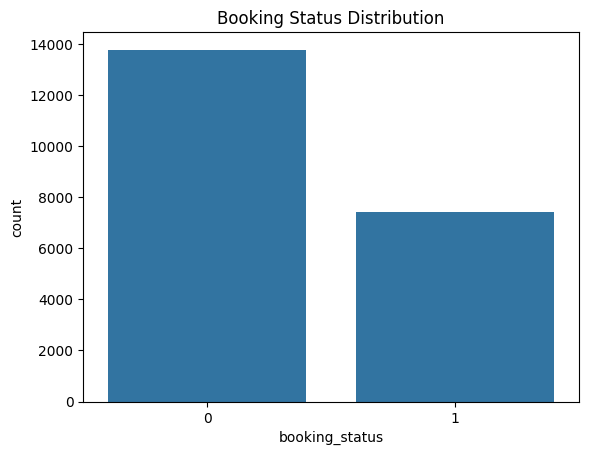

In [80]:
#plot_relationships(df, 'booking_status')
sns.countplot(x=df['booking_status'], data=df)
plt.title('Booking Status Distribution')
plt.show()

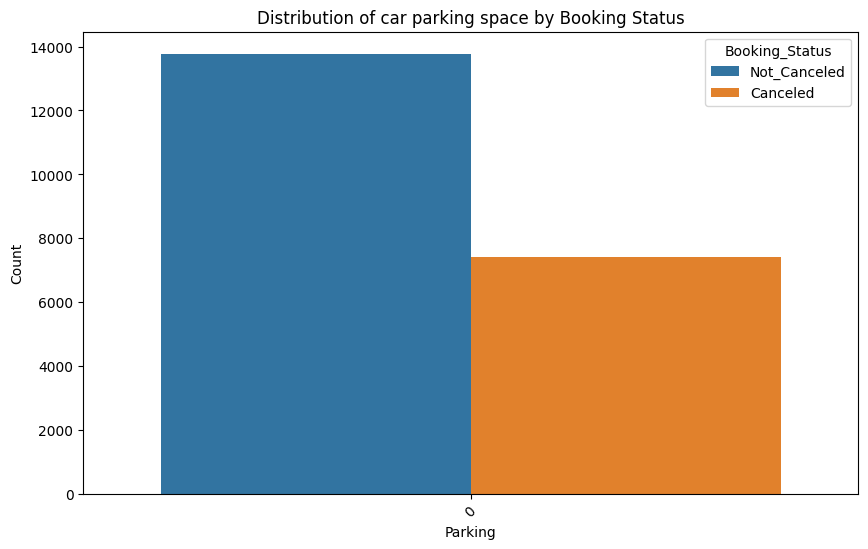

In [81]:
# Set plot size
plt.figure(figsize=(10, 6))

# Create count plot
sns.countplot(x='car_parking_space', hue='booking_status', data=df)
plt.title('Distribution of car parking space by Booking Status')
plt.xlabel('Parking')
plt.ylabel('Count')
plt.legend(title='Booking_Status', labels=['Not_Canceled', 'Canceled'])
plt.xticks(rotation=45)
plt.show()

In [82]:
# Replace True/False with 1/0 across all columns
df = df.replace({True: 1, False: 0})

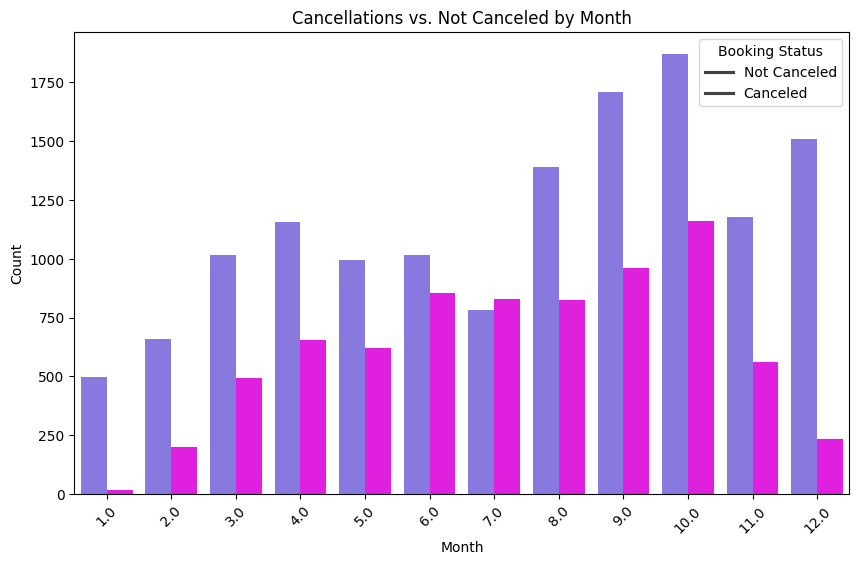

In [83]:
# Convert 'date_of_reservation' to datetime if not already
df['date_of_reservation'] = pd.to_datetime(df['date_of_reservation'], errors='coerce')

# Extract month from the date
df['Month'] = df['date_of_reservation'].dt.month

# Count cancellations by month for both 'Canceled' and 'Not Canceled'
cancellations_by_month = df.groupby(['Month', 'booking_status']).size().reset_index(name='Count')

# Ensure 'booking_status' is of type int
cancellations_by_month['booking_status'] = cancellations_by_month['booking_status'].astype(int)

# Define custom color palette using numerical values
custom_palette = {0: '#7b68ee', 1: '#ff00ff'}

# Plot cancellations by month with hue differentiation
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Count', hue='booking_status', data=cancellations_by_month, palette=custom_palette)
plt.title('Cancellations vs. Not Canceled by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Booking Status', labels=['Not Canceled', 'Canceled'])
plt.show()

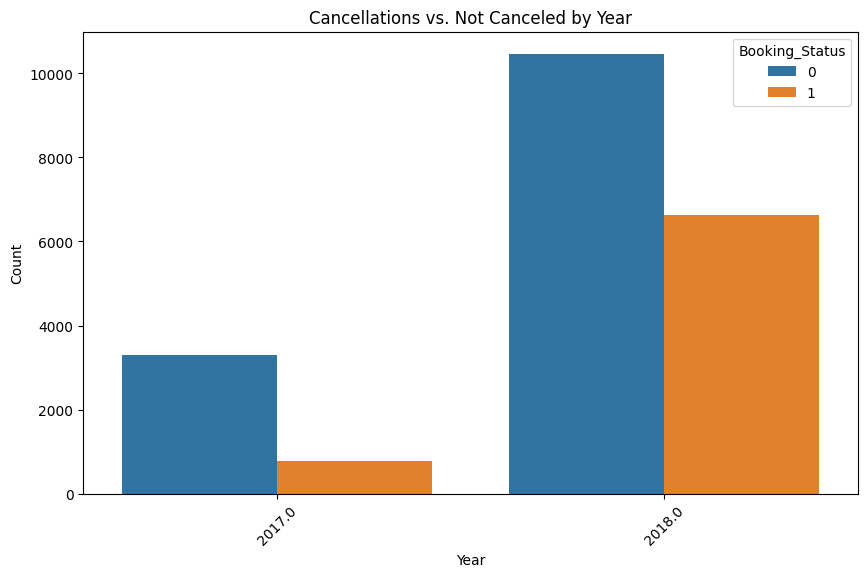

In [84]:
df['date_of_reservation'] = pd.to_datetime(df['date_of_reservation'], errors='coerce')

# Extract year from the date
df['Year'] = df['date_of_reservation'].dt.year

# Count cancellations by year for both 'Canceled' and 'Not Canceled'
cancellations_by_year = df.groupby(['Year', 'booking_status']).size().reset_index(name='Count')


# Plot cancellations by year with hue differentiation
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Count', hue='booking_status', data=cancellations_by_year)
plt.title('Cancellations vs. Not Canceled by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Booking_Status')
plt.show()

Plotting numerical columns: 100%|██████████| 26/26 [00:02<00:00, 12.56it/s]
Plotting categorical columns: 0it [00:00, ?it/s]


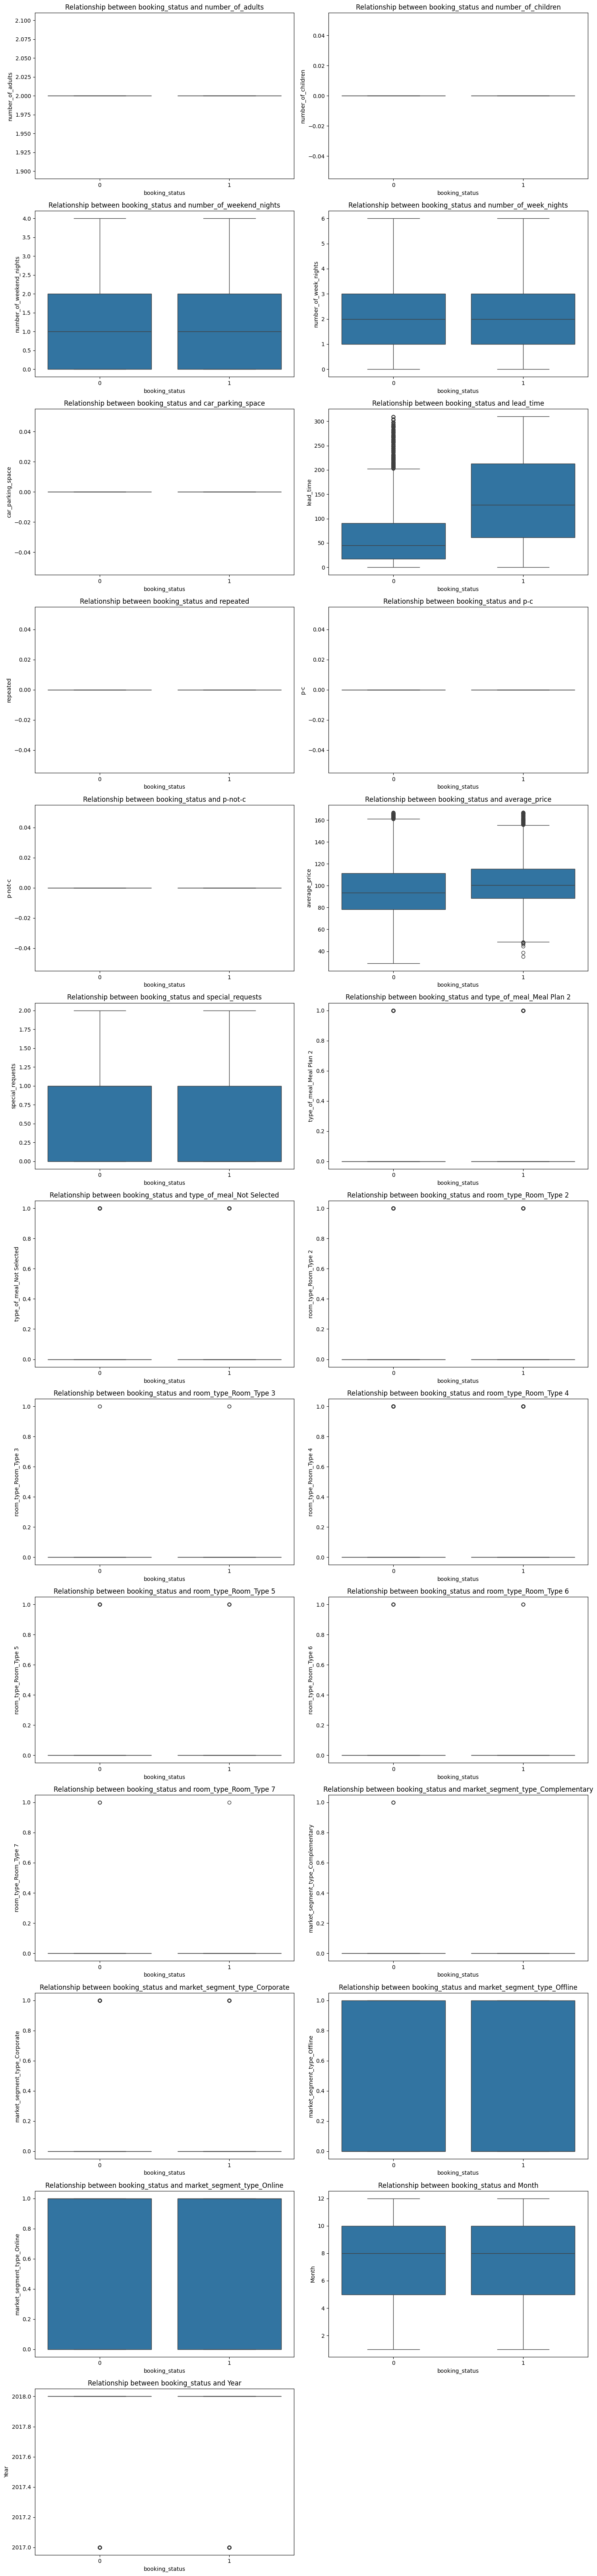

In [85]:
#plot using our function
plot_relationships(df, 'booking_status')


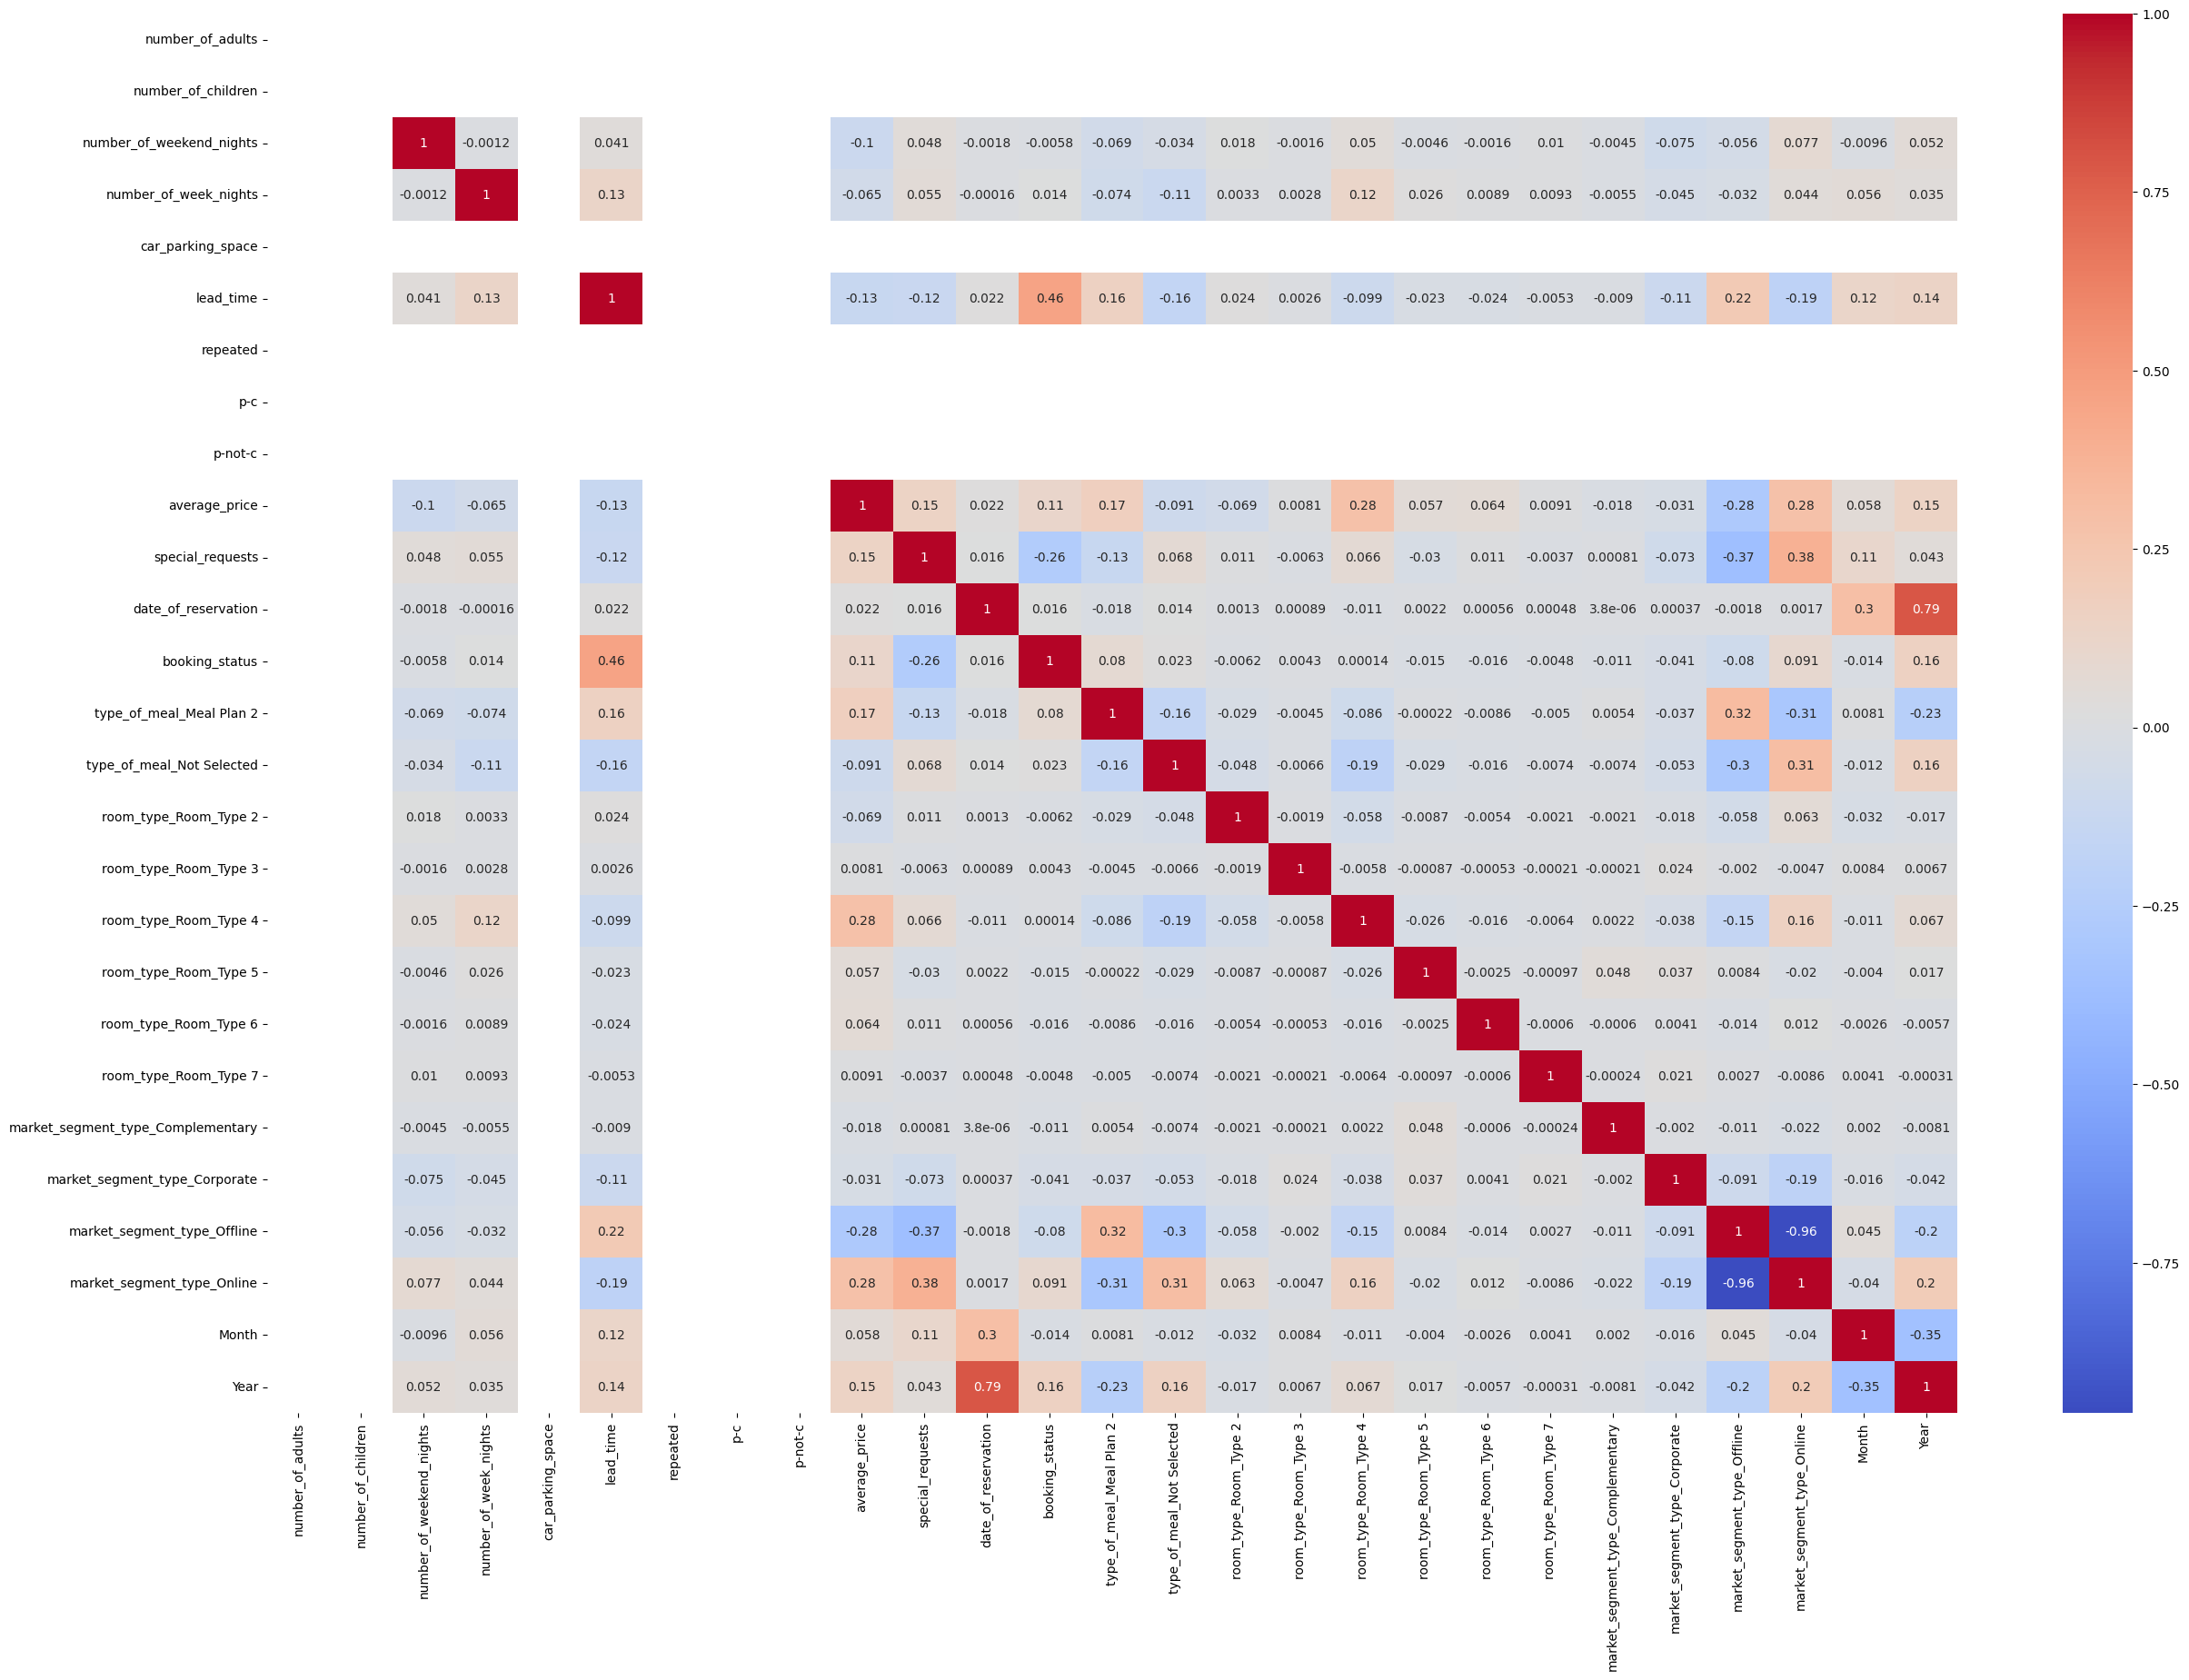

High correlation features:  ['booking_status']


In [86]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Select features that have high correlation with the target variable
target_variable = 'booking_status'
correlation_threshold = 0.85
high_correlation_features = corr_matrix.index[abs(corr_matrix[target_variable]) > correlation_threshold].tolist()

# Print high correlation features
print("High correlation features: ", high_correlation_features)

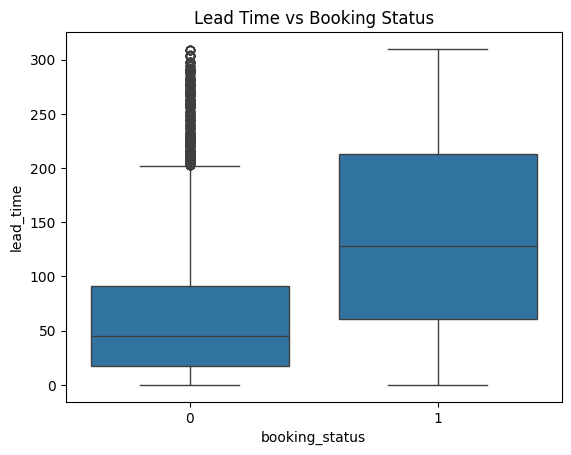

In [87]:
sns.boxplot(x='booking_status', y='lead_time', data=df)
plt.title('Lead Time vs Booking Status')
plt.show()

In [88]:
print(df.columns)
df.head()

Index(['number_of_adults', 'number_of_children', 'number_of_weekend_nights',
       'number_of_week_nights', 'car_parking_space', 'lead_time', 'repeated',
       'p-c', 'p-not-c', 'average_price', 'special_requests',
       'date_of_reservation', 'booking_status', 'type_of_meal_Meal Plan 2',
       'type_of_meal_Not Selected', 'room_type_Room_Type 2',
       'room_type_Room_Type 3', 'room_type_Room_Type 4',
       'room_type_Room_Type 5', 'room_type_Room_Type 6',
       'room_type_Room_Type 7', 'market_segment_type_Complementary',
       'market_segment_type_Corporate', 'market_segment_type_Offline',
       'market_segment_type_Online', 'Month', 'Year'],
      dtype='object')


number_of_adults  number_of_children  number_of_weekend_nights  \
12                 2                   0                         2   
14                 2                   0                         0   
15                 2                   0                         0   
17                 2                   0                         1   
18                 2                   0                         2   

    number_of_week_nights  car_parking_space  lead_time  repeated  p-c  \
12                      1                  0         30         0    0   
14                      2                  0         47         0    0   
15                      2                  0        256         0    0   
17                      3                  0          1         0    0   
18                      2                  0         99         0    0   

    p-not-c  average_price  ...  room_type_Room_Type 4 room_type_Room_Type 5  \
12        0           88.0  ...                      0                     0   
14        0           94.5  ...                      0                     0   
15        0          115.0  ...                      0                     0   
17        0           96.0  ...                      0                     0   
18        0           65.0  ...                      0                     0   

    room_type_Room_Type 6  room_type_Room_Type 7  \
12                      0                      0   
14                      0                      0   
15                      0                      0   
17                      0                      0   
18                      0                      0   

    market_segment_type_Complementary  market_segment_type_Corporate  \
12                                  0                              0   
14                                  0                              0   
15                                  0                              0   
17                                  0                              0   
18                                  0                              0   

    market_segment_type_Offline  market_segment_type_Online  Month    Year  
12                            0                           1   11.0  2018.0  
14                            0                           1   10.0  2017.0  
15                            0                           1    6.0  2018.0  
17                            0                           1    8.0  2017.0  
18                            0                           1   10.0  2017.0  

[5 rows x 27 columns]

In [89]:
# Replace True/False with 1/0 across all columns
df = df.replace({True: 1, False: 0})

df.head()


number_of_adults  number_of_children  number_of_weekend_nights  \
12                 2                   0                         2   
14                 2                   0                         0   
15                 2                   0                         0   
17                 2                   0                         1   
18                 2                   0                         2   

    number_of_week_nights  car_parking_space  lead_time  repeated  p-c  \
12                      1                  0         30         0    0   
14                      2                  0         47         0    0   
15                      2                  0        256         0    0   
17                      3                  0          1         0    0   
18                      2                  0         99         0    0   

    p-not-c  average_price  ...  room_type_Room_Type 4 room_type_Room_Type 5  \
12        0           88.0  ...                      0                     0   
14        0           94.5  ...                      0                     0   
15        0          115.0  ...                      0                     0   
17        0           96.0  ...                      0                     0   
18        0           65.0  ...                      0                     0   

    room_type_Room_Type 6  room_type_Room_Type 7  \
12                      0                      0   
14                      0                      0   
15                      0                      0   
17                      0                      0   
18                      0                      0   

    market_segment_type_Complementary  market_segment_type_Corporate  \
12                                  0                              0   
14                                  0                              0   
15                                  0                              0   
17                                  0                              0   
18                                  0                              0   

    market_segment_type_Offline  market_segment_type_Online  Month    Year  
12                            0                           1   11.0  2018.0  
14                            0                           1   10.0  2017.0  
15                            0                           1    6.0  2018.0  
17                            0                           1    8.0  2017.0  
18                            0                           1   10.0  2017.0  

[5 rows x 27 columns]

In [90]:
#check nan values
nan_values = df.isnull().sum()
print(nan_values)

number_of_adults                      0
number_of_children                    0
number_of_weekend_nights              0
number_of_week_nights                 0
car_parking_space                     0
lead_time                             0
repeated                              0
p-c                                   0
p-not-c                               0
average_price                         0
special_requests                      0
date_of_reservation                  11
booking_status                        0
type_of_meal_Meal Plan 2              0
type_of_meal_Not Selected             0
room_type_Room_Type 2                 0
room_type_Room_Type 3                 0
room_type_Room_Type 4                 0
room_type_Room_Type 5                 0
room_type_Room_Type 6                 0
room_type_Room_Type 7                 0
market_segment_type_Complementary     0
market_segment_type_Corporate         0
market_segment_type_Offline           0
market_segment_type_Online            0


In [91]:
#remove nan values
df = df.dropna()

These features have low correlation with booking_status, implying they might not be very predictive:

number_of_adults (0.093)

number_of_weekend_nights (0.093)

number_of_week_nights (0.080)

car_parking_space (0.088)

p_c (0.034)

Final step:

Training the model using different classifiers [logistic regression , random forest , decision tree] and choose best accuracy out of them

In [94]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer

# Example: assuming df is your DataFrame with datetime columns
df['reservation_year'] = pd.to_datetime(df['date_of_reservation']).dt.year
df['reservation_day'] = pd.to_datetime(df['date_of_reservation']).dt.day

# Drop the original date_of_reservation column and non-numeric columns
drop_columns = ['date_of_reservation', 'booking_status']  # Adjust as needed
X = df.drop(drop_columns, axis=1)
y = df['booking_status']

# Define a function to convert non-numeric columns to numeric
def to_numeric(df):
    return df.apply(pd.to_numeric, errors='coerce')

# Use FunctionTransformer with the defined function
transformer = FunctionTransformer(to_numeric, validate=False)
X_numeric = transformer.fit_transform(X)

# Initialize model and RFE
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
fit = rfe.fit(X_numeric, y)

# Print results
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

# Print selected features and their ranks
for i, col in enumerate(X.columns):
    print(f"{col} selected = {fit.support_[i]} rank = {fit.ranking_[i]}")


Num Features: 10
Selected Features: [False False  True  True False  True False False False  True  True False
 False False False False False False False False False  True  True  True
  True False  True]
Feature Ranking: [18 17  1  1 16  1 14 13 15  1  1  3  2  6 11  5  8  9 12 10  7  1  1  1
  1  4  1]
number_of_adults selected = False rank = 18
number_of_children selected = False rank = 17
number_of_weekend_nights selected = True rank = 1
number_of_week_nights selected = True rank = 1
car_parking_space selected = False rank = 16
lead_time selected = True rank = 1
repeated selected = False rank = 14
p-c selected = False rank = 13
p-not-c selected = False rank = 15
average_price selected = True rank = 1
special_requests selected = True rank = 1
type_of_meal_Meal Plan 2 selected = False rank = 3
type_of_meal_Not Selected selected = False rank = 2
room_type_Room_Type 2 selected = False rank = 6
room_type_Room_Type 3 selected = False rank = 11
room_type_Room_Type 4 selected = False rank = 5

<Axes: >

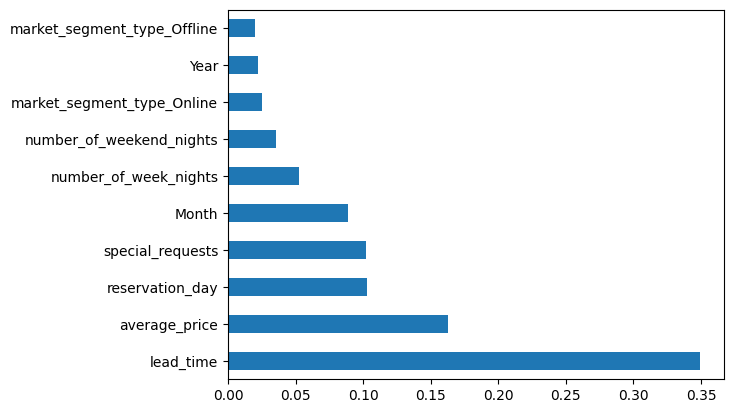

In [70]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
feature_names = X.columns

feat_importances = pd.Series(importances, index=feature_names)
feat_importances.nlargest(10).plot(kind='barh')


In [76]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.feature_selection import SelectKBest

# Load your data
# Assuming df is already loaded
drop = ['reservation_year', 'booking_status']
X = df.drop(drop, axis=1)
y = df['booking_status']

# Define a custom scoring function using Spearman correlation
def spearman_corr(X, y):
    scores = []
    for i in range(X.shape[1]):
        corr, _ = spearmanr(X[:, i], y)
        scores.append(abs(corr))
    return np.array(scores)

# Convert X to a numpy array
X_np = X.values

# Apply SelectKBest with the custom Spearman scoring function
spearman_selector = SelectKBest(score_func=spearman_corr, k=10)
X_spearman_selected = spearman_selector.fit_transform(X_np, y)

# Get the selected features
spearman_selected_features = X.columns[spearman_selector.get_support()]

print("Spearman Selected Features:")
print(spearman_selected_features)


Spearman Selected Features:
Index(['lead_time', 'average_price', 'special_requests',
       'type_of_meal_Meal Plan 2', 'type_of_meal_Not Selected',
       'market_segment_type_Corporate', 'market_segment_type_Offline',
       'market_segment_type_Online', 'Month', 'Year'],
      dtype='object')


c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [33]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

# Load your data
# Assuming df is already loaded
drop_columns = ['reservation_year', 'booking_status']
X = df.drop(drop_columns, axis=1)
y = df['booking_status']

# Convert non-numeric columns to numeric, handling errors and NaNs
X_numeric = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Apply SelectKBest with f_regression scoring function
f_regression_selector = SelectKBest(score_func=f_regression, k=10)
X_f_regression_selected = f_regression_selector.fit_transform(X_numeric, y)

# Get the selected features
f_regression_selected_features = X_numeric.columns[f_regression_selector.get_support()]

print("F-Regression Selected Features:")
print(f_regression_selected_features)


F-Regression Selected Features:
Index(['lead_time', 'average_price', 'special_requests', 'date_of_reservation',
       'type_of_meal_Meal Plan 2', 'type_of_meal_Not Selected',
       'market_segment_type_Corporate', 'market_segment_type_Offline',
       'market_segment_type_Online', 'Year'],
      dtype='object')


In [31]:
import pandas as pd
import numpy as np

# Assuming df is already loaded and you want to drop some columns
drop = ['reservation_year', 'booking_status']
X = df.drop(drop, axis=1)
y = df['booking_status']

# Ensure all columns are numeric for Pearson correlation calculation
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Calculate Pearson correlation coefficients between each feature and the target variable
correlations = X.corrwith(y, method='pearson')

# Select the top 10 features with the highest absolute correlation values
top_k_features = correlations.abs().nlargest(10).index

# Get the selected features
pearson_selected_features = top_k_features

print("Pearson Selected Features:")
print(pearson_selected_features)


Pearson Selected Features:
Index(['lead_time', 'special_requests', 'Year', 'date_of_reservation',
       'average_price', 'market_segment_type_Online',
       'type_of_meal_Meal Plan 2', 'market_segment_type_Offline',
       'market_segment_type_Corporate', 'type_of_meal_Not Selected'],
      dtype='object')


In [77]:
selected_features = [
    'lead_time',
    'average_price',
    'special_requests',
    'reservation_day',
    'Month',
    'number_of_week_nights',
    'type_of_meal_Meal Plan 2',
    'type_of_meal_Not Selected',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'market_segment_type_Corporate',
    'room_type_Room_Type 6',
]
# Define features and target variable
X = df[selected_features]
y = df['booking_status']

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X, y)

print(grid_search.best_params_)


c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.p

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}


In [79]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=200, num=10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X, y)

print(random_search.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.

{'n_estimators': 177, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


In [80]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

def objective(params):
    clf = RandomForestClassifier(**params)
    return -cross_val_score(clf, X, y, cv=3, scoring='accuracy').mean()

space = {
    'n_estimators': hp.choice('n_estimators', range(100, 500)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)


100%|██████████| 100/100 [12:39<00:00,  7.60s/trial, best loss: -0.7523365519890962]
{'criterion': 1, 'max_depth': 2, 'min_samples_leaf': 0.13377179498282046, 'min_samples_split': 0.26434953318131205, 'n_estimators': 13}


KNN

In [81]:
#import knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

selected_features = [
    'lead_time',
    'average_price',
    'special_requests',
    'reservation_day',
    'Month',
    'number_of_week_nights',
    'type_of_meal_Meal Plan 2',
    'type_of_meal_Not Selected',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'market_segment_type_Corporate',
    'room_type_Room_Type 6',
]
# Define features and target variable
X = df[selected_features]
y = df['booking_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Knn model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2423  338]
 [ 527  948]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2761
           1       0.74      0.64      0.69      1475

    accuracy                           0.80      4236
   macro avg       0.78      0.76      0.77      4236
weighted avg       0.79      0.80      0.79      4236



Logistic Regression


In [82]:
selected_features = [
    'lead_time',
    'average_price',
    'special_requests',
    'reservation_day',
    'Month',
    'number_of_week_nights',
    'type_of_meal_Meal Plan 2',
    'type_of_meal_Not Selected',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'market_segment_type_Corporate',
    'room_type_Room_Type 6',
]
# Define features and target variable
X = df[selected_features]
y = df['booking_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2474  287]
 [ 520  955]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2761
           1       0.77      0.65      0.70      1475

    accuracy                           0.81      4236
   macro avg       0.80      0.77      0.78      4236
weighted avg       0.81      0.81      0.81      4236



c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DecisionTree 

In [83]:
selected_features = [
    'lead_time',
    'average_price',
    'special_requests',
    'reservation_day',
    'Month',
    'number_of_week_nights',
    'type_of_meal_Meal Plan 2',
    'type_of_meal_Not Selected',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'market_segment_type_Corporate',
    'room_type_Room_Type 6',
]
# Define features and target variable
X = df[selected_features]
y = df['booking_status']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2446  315]
 [ 301 1174]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2761
           1       0.79      0.80      0.79      1475

    accuracy                           0.85      4236
   macro avg       0.84      0.84      0.84      4236
weighted avg       0.85      0.85      0.85      4236



RandomForest with no tunning

In [99]:
selected_features = [
    'lead_time',
    'average_price',
    'special_requests',
    'reservation_day',
    'Month',
    'number_of_week_nights',
    'type_of_meal_Meal Plan 2',
    'type_of_meal_Not Selected',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'market_segment_type_Corporate',
    'room_type_Room_Type 6',
]
# Define features and target variable
X = df[selected_features]
y = df['booking_status']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2582  179]
 [ 299 1176]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2761
           1       0.87      0.80      0.83      1475

    accuracy                           0.89      4236
   macro avg       0.88      0.87      0.87      4236
weighted avg       0.89      0.89      0.89      4236



In [92]:
selected_features = [
    'lead_time',
    'average_price',
    'special_requests',
    'reservation_day',
    'Month',
    'number_of_week_nights',
    'type_of_meal_Meal Plan 2',
    'type_of_meal_Not Selected',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'market_segment_type_Corporate',
    'room_type_Room_Type 6',
]
# Define features and target variable
X = df[selected_features]
y = df['booking_status']

# Parameters from GridSearchCV
params_gridsearch = {
    'n_estimators': 200,
    'max_features': 'log2',
    'max_depth': 8,
    'criterion': 'gini'
}

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model with GridSearchCV tuned parameters
clf_gridsearch = RandomForestClassifier(**params_gridsearch)
clf_gridsearch.fit(X_train, y_train)

# Evaluate
y_pred_gridsearch = clf_gridsearch.predict(X_test)
accuracy_gridsearch = accuracy_score(y_test, y_pred_gridsearch)

print("Accuracy with GridSearchCV parameters:", accuracy_gridsearch)

Accuracy with GridSearchCV parameters: 0.852219074598678


In [103]:
selected_features = [
    'lead_time',
    'average_price',
    'special_requests',
    'reservation_day',
    'Month',
    'number_of_week_nights',
    'type_of_meal_Meal Plan 2',
    'type_of_meal_Not Selected',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'market_segment_type_Corporate',
    'room_type_Room_Type 6',
]
# Define features and target variable
X = df[selected_features]
y = df['booking_status']

# Parameters from RandomizedSearchCV
params_randomizedsearch = {
    'n_estimators': 177,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 30,
    'bootstrap': True
}

# Model with RandomizedSearchCV tuned parameters
clf_randomizedsearch = RandomForestClassifier(**params_randomizedsearch)
clf_randomizedsearch.fit(X_train, y_train)

# Evaluate
y_pred_randomizedsearch = clf_randomizedsearch.predict(X_test)
accuracy_randomizedsearch = accuracy_score(y_test, y_pred_randomizedsearch)

print("Accuracy with RandomizedSearchCV parameters:", accuracy_randomizedsearch)

Accuracy with RandomizedSearchCV parameters: 0.8878659112370161


In [97]:
selected_features = [
    'lead_time',
    'average_price',
    'special_requests',
    'reservation_day',
    'Month',
    'number_of_week_nights',
    'type_of_meal_Meal Plan 2',
    'type_of_meal_Not Selected',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'market_segment_type_Corporate',
    'room_type_Room_Type 6',
]
# Define features and target variable
X = df[selected_features]
y = df['booking_status']

# Parameters from Hyperopt
params_hyperopt = {
    'n_estimators': 138,
    'max_depth': 2,
    'min_samples_leaf': 0.13377179498282046,
    'min_samples_split': 0.26434953318131205,
    'criterion': 'entropy'
}

# Model with Hyperopt tuned parameters
clf_hyperopt = RandomForestClassifier(**params_hyperopt)
clf_hyperopt.fit(X_train, y_train)

# Evaluate
y_pred_hyperopt = clf_hyperopt.predict(X_test)
accuracy_hyperopt = accuracy_score(y_test, y_pred_hyperopt)

print("Accuracy with Hyperopt parameters:", accuracy_hyperopt)


Accuracy with Hyperopt parameters: 0.7195467422096318


XGBoost


In [98]:
selected_features = [
    'lead_time',
    'average_price',
    'special_requests',
    'reservation_day',
    'Month',
    'number_of_week_nights',
    'type_of_meal_Meal Plan 2',
    'type_of_meal_Not Selected',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'market_segment_type_Corporate',
    'room_type_Room_Type 6',
]
# Define features and target variable
X = df[selected_features]
y = df['booking_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a XGBoost model
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2552  209]
 [ 304 1171]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2761
           1       0.85      0.79      0.82      1475

    accuracy                           0.88      4236
   macro avg       0.87      0.86      0.86      4236
weighted avg       0.88      0.88      0.88      4236



Plot the learning_curve

In [104]:
# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1) 

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

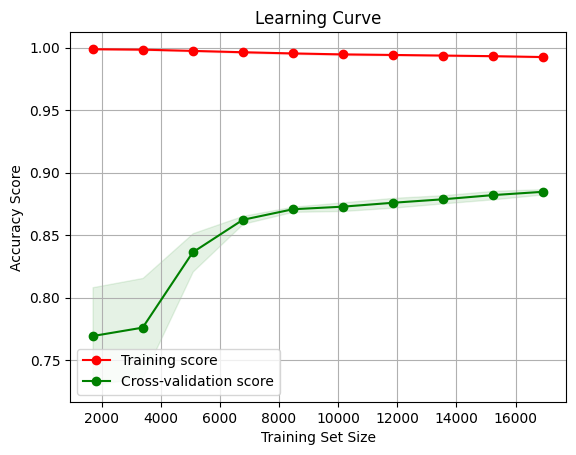

In [105]:
# Plotting the learning curve
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
# Plot the standard deviation as a shaded region
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

# Create plot
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc="best")
plt.grid()
plt.show()

In [106]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Assuming df is your DataFrame

selected_features = [
    'lead_time',
    'average_price',
    'special_requests',
    'reservation_day',
    'Month',
    'number_of_week_nights',
    'type_of_meal_Meal Plan 2',
    'type_of_meal_Not Selected',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'market_segment_type_Corporate',
    'room_type_Room_Type 6',
]

# Define features and target variable
X = df[selected_features]
y = df['booking_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parameters from RandomizedSearchCV
params_randomizedsearch = {
    'n_estimators': 177,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 30,
    'bootstrap': True
}

# Model with RandomizedSearchCV tuned parameters
clf_randomizedsearch = RandomForestClassifier(**params_randomizedsearch)

# Cross-validation
cv_scores = cross_val_score(clf_randomizedsearch, X_train_scaled, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {np.mean(cv_scores)}')

# Train the model
clf_randomizedsearch.fit(X_train_scaled, y_train)

# Evaluate
y_pred_randomizedsearch = clf_randomizedsearch.predict(X_test_scaled)
accuracy_randomizedsearch = accuracy_score(y_test, y_pred_randomizedsearch)

print("Accuracy with RandomizedSearchCV parameters:", accuracy_randomizedsearch)


Cross-validation scores: [0.88397976 0.87892074 0.87824621 0.88060708 0.87550607]
Mean cross-validation score: 0.8794519734281872
Accuracy with RandomizedSearchCV parameters: 0.882121498268807


Cross-validation scores: [0.85969646 0.86475548 0.85463744 0.85969646 0.84345479]
Mean cross-validation score: 0.8564481251123658
Accuracy with updated parameters: 0.863707900535096


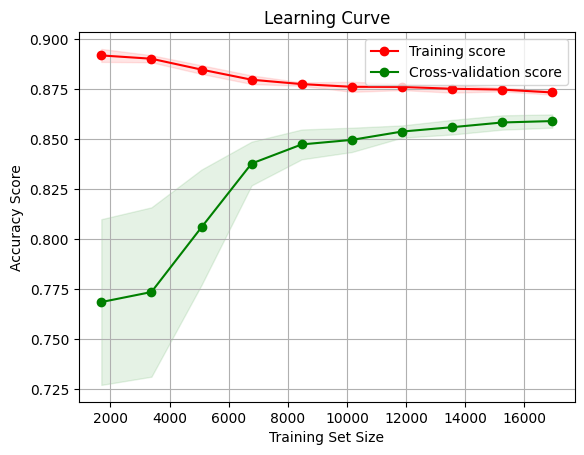

In [112]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Assuming df is your DataFrame

selected_features = [
    'lead_time',
    'average_price',
    'special_requests',
    'reservation_day',
    'Month',
    'number_of_week_nights',
    'type_of_meal_Meal Plan 2',
    'type_of_meal_Not Selected',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'market_segment_type_Corporate',
    'room_type_Room_Type 6',
]

# Define features and target variable
X = df[selected_features]
y = df['booking_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Updated hyperparameters with more regularization
params_updated = {
    'n_estimators': 100,  # Reduced number of trees
    'min_samples_split': 5,  # Increased min samples to split
    'min_samples_leaf': 4,  # Increased min samples per leaf
    'max_features': 'sqrt',
    'max_depth': 10,  # Reduced max depth
    'bootstrap': True
}

# Model with updated parameters
clf_updated = RandomForestClassifier(**params_updated)

# Cross-validation
cv_scores = cross_val_score(clf_updated, X_train_scaled, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {np.mean(cv_scores)}')

# Train the model
clf_updated.fit(X_train_scaled, y_train)

# Evaluate
y_pred_updated = clf_updated.predict(X_test_scaled)
accuracy_updated = accuracy_score(y_test, y_pred_updated)

print("Accuracy with updated parameters:", accuracy_updated)

# Plot learning curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, valid_scores = learning_curve(clf_updated, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color='r')
plt.fill_between(train_sizes, np.mean(valid_scores, axis=1) - np.std(valid_scores, axis=1),
                 np.mean(valid_scores, axis=1) + np.std(valid_scores, axis=1), alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


Model Extraction

In [102]:
import joblib

# Save the model
joblib.dump(model, 'model.joblib')


['model.joblib']

In [113]:
import joblib

# Assuming the model is trained
clf_updated.fit(X_train_scaled, y_train)

# Save the model to a file
model_filename = 'random_forest_model.joblib'
joblib.dump(clf_updated, model_filename)
print(f'Model saved to {model_filename}')


Model saved to random_forest_model.joblib
